In [1]:
# install the google api client

!pip install google-api-python-client


In [38]:
pip install pandoc

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 3.9 MB/s eta 0:00:00
  Created wheel for pandoc: filename=pandoc-2.4-py3-none-any.whl size=34792 sha256=96161a433c60e415f382597fc5f1beea997cf0a9544f4eeadfd69e5e94910f12
  Stored in directory: /Users/dilshad/Library/Caches/pip/wheels/10/f8/26/ddf077e60385563a3fef3afad369a40b22e59603a700ec23e4
Successfully built pandoc
Note: you may need to restart the kernel to use updated packages.


### Import the libraries

In [2]:
pip install isodate

Note: you may need to restart the kernel to use updated packages.


In [4]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import isodate

### Connect to the API Client

In [5]:
api_key='AIzaSyCyLuZ0crF5wlJNA_A-NU'
channel_ids=['UCmTM_hPCeckqN3cPWtYZZcg',
             'UCzI8K9xO_5E-4iCP7Km6cRQ',
             'UC5fcjujOsqD-126Chn_BAuA',
             'UC-CSyyi47VX1lD9zyeABW3w',
             'UC0yXUUIaPVAqZLgRjvtMftw',
             'UCWtlPzcP989da26sVyHPzqQ']

youtube = build('youtube','v3',developerKey=api_key)

## Define functions to get...

#### Channel Details, List of video ids for the playlists, Details of videos

In [6]:
def get_channel_stats(youtube, channel_ids):
    
    all_channels=[]
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(channel_name = response['items'][i]['snippet']['title'],
                channel_id= response['items'][i]['id'],
                ch_subscribers = response['items'][i]['statistics']['subscriberCount'],
                views = response['items'][i]['statistics']['viewCount'],
                total_videos = response['items'][i]['statistics']['videoCount'],
                playlist_id= response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
    
        all_channels.append(data)
    
    return all_channels


In [7]:
def get_videos_from_playlists(youtube, playlist_ids):
    all_video_ids = []

    for playlist_id in playlist_ids:
        video_ids = []
        next_page_token = None
        more_pages = True

        while more_pages:
            request = youtube.playlistItems().list(
                part="contentDetails",
                playlistId=playlist_id,
                maxResults=50,
                pageToken=next_page_token
            )
            response = request.execute()

            for item in response.get('items', []):
                video_ids.append(item['contentDetails']['videoId'])

            next_page_token = response.get('nextPageToken')
            if next_page_token is None:
                more_pages = False

        all_video_ids.extend(video_ids)

    return all_video_ids

In [8]:
def get_videos_data(youtube, video_ids):
    
    video_details=[]
    for i in range(0, len(video_ids), 50):
        
        request = youtube.videos().list(
            part ="snippet,statistics,contentDetails",
            id = ','.join(video_ids[i:i+50]))
        response = request.execute()

        for video in response['items']:
            stats = video.get('statistics', {})
            video_data=dict(video_id = video['id'],
                            title = video['snippet']['title'],
                            channel_id = video['snippet']['channelId'],
                            publish_date = video['snippet']['publishedAt'],
                            duration = video['contentDetails']['duration'],
                            views = stats.get('viewCount'),
                            likes = stats.get('likeCount'),
                            fav_count = stats.get('favoriteCount'))
            video_details.append(video_data)
            
    return video_details

In [9]:
# Function to convert duration in minutes

def iso_duration_to_minutes(duration):
    hours = minutes = seconds = 0
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?', duration)
    if match:
        hours = int(match.group(1) or 0)
        minutes = int(match.group(2) or 0)
        seconds = int(match.group(3) or 0)
    return hours * 60 + minutes + seconds / 60

# Function to conver to actual values mmss
def minutes_to_mmss(value):
    if pd.isna(value):  # handle NaN or None
        return None
    minutes = int(value)
    seconds = round((value - minutes) * 60)
    return f"{minutes:02d}:{seconds:02d}"

### Read data into dataframes

In [10]:
channels=get_channel_stats(youtube, channel_ids)
yt_channels=pd.DataFrame(channels)
yt_channels.head()

,channel_name,channel_id,ch_subscribers,views,total_videos,playlist_id
0,Dhruv Rathee,UC-CSyyi47VX1lD9zyeABW3w,30100000,4771023931,706,UU-CSyyi47VX1lD9zyeABW3w
1,Paurush Sharma,UCWtlPzcP989da26sVyHPzqQ,1620000,268233772,959,UUWtlPzcP989da26sVyHPzqQ
2,Sarthak Goswami,UC5fcjujOsqD-126Chn_BAuA,1500000,717111380,1319,UU5fcjujOsqD-126Chn_BAuA
3,Faye D'Souza,UCzI8K9xO_5E-4iCP7Km6cRQ,435000,69171557,3186,UUzI8K9xO_5E-4iCP7Km6cRQ
4,The Deshbhakt,UCmTM_hPCeckqN3cPWtYZZcg,6180000,943874707,642,UUmTM_hPCeckqN3cPWtYZZcg


In [11]:
# Pick only one playlist ID to run (test) & get the video_id list
# playlist_id=yt_channels.loc[yt_channels['channel_name']=='The Deshbhakt','playlist_id'].iloc[0]
playlist_ids = yt_channels['playlist_id']
video_ids=get_videos_from_playlists(youtube, playlist_ids)

In [12]:
# get the details for all video_ids of the test playlist

video_details=get_videos_data(youtube, video_ids)
yt_video_data = pd.DataFrame(video_details)
yt_video_data.head()

,video_id,title,channel_id,publish_date,duration,views,likes,fav_count
0,V9bLCcBGt9g,Reality of KBC Kid | Why are Kids becoming Arr...,UC-CSyyi47VX1lD9zyeABW3w,2025-10-19T16:02:42Z,PT19M34S,5928503,268531,0
1,9sp4pP6bB08,The Crazy Story of Sleepwalking K*ller | Dhruv...,UC-CSyyi47VX1lD9zyeABW3w,2025-10-16T17:18:20Z,PT23M6S,4569000,190046,0
2,SU1MxWTFJu0,This is what happens when you start your own c...,UC-CSyyi47VX1lD9zyeABW3w,2025-10-12T15:34:58Z,PT21M44S,3106870,158885,0
3,JTZ55i-8dGk,India’s Most Fearless Singer | The Truth About...,UC-CSyyi47VX1lD9zyeABW3w,2025-10-04T18:02:47Z,PT16M16S,9333461,714834,0
4,j0uwqcjDa4Y,Sonam Wangchuk Arrested! | Is India still a Fr...,UC-CSyyi47VX1lD9zyeABW3w,2025-09-30T16:13:05Z,PT28M6S,9854165,656480,0


In [13]:
# Merge the video data with the channel information

channel_sub = yt_channels[['channel_id','channel_name','ch_subscribers']]
channel_sub=channel_sub.set_index('channel_id')

yt_data=pd.merge(yt_video_data, channel_sub, on='channel_id', how='left')
yt_data.head()

,video_id,title,channel_id,publish_date,duration,views,likes,fav_count,channel_name,ch_subscribers
0,V9bLCcBGt9g,Reality of KBC Kid | Why are Kids becoming Arr...,UC-CSyyi47VX1lD9zyeABW3w,2025-10-19T16:02:42Z,PT19M34S,5928503,268531,0,Dhruv Rathee,30100000
1,9sp4pP6bB08,The Crazy Story of Sleepwalking K*ller | Dhruv...,UC-CSyyi47VX1lD9zyeABW3w,2025-10-16T17:18:20Z,PT23M6S,4569000,190046,0,Dhruv Rathee,30100000
2,SU1MxWTFJu0,This is what happens when you start your own c...,UC-CSyyi47VX1lD9zyeABW3w,2025-10-12T15:34:58Z,PT21M44S,3106870,158885,0,Dhruv Rathee,30100000
3,JTZ55i-8dGk,India’s Most Fearless Singer | The Truth About...,UC-CSyyi47VX1lD9zyeABW3w,2025-10-04T18:02:47Z,PT16M16S,9333461,714834,0,Dhruv Rathee,30100000
4,j0uwqcjDa4Y,Sonam Wangchuk Arrested! | Is India still a Fr...,UC-CSyyi47VX1lD9zyeABW3w,2025-09-30T16:13:05Z,PT28M6S,9854165,656480,0,Dhruv Rathee,30100000


## Data Exploration & Cleaning

In [14]:
yt_data.describe()

,video_id,title,channel_id,publish_date,duration,views,likes,fav_count,channel_name,ch_subscribers
count,8049,8049,8049,8049,8049,8049,8038,8049,8049,8049
unique,8049,8031,6,8047,2305,7667,5706,1,6,6
top,V9bLCcBGt9g,"Headlines - 17th July, 2021",UCzI8K9xO_5E-4iCP7Km6cRQ,2021-02-19T15:00:14Z,PT1M,2558,31,0,Faye D'Souza,435000
freq,1,4,3185,2,134,5,31,8049,3185,3185


In [15]:
yt_data.dtypes

video_id          object
title             object
channel_id        object
publish_date      object
duration          object
views             object
likes             object
fav_count         object
channel_name      object
ch_subscribers    object
dtype: object

In [16]:
# change the format for publish_date, view, likes, fav_ccount

yt_data['views']=pd.to_numeric(yt_data['views'], errors='coerce')
yt_data['likes']=pd.to_numeric(yt_data['likes'], errors='coerce')
yt_data['fav_count']=pd.to_numeric(yt_data['fav_count'], errors='coerce')
yt_data['ch_subscribers']=pd.to_numeric(yt_data['ch_subscribers'], errors='coerce')
yt_data.dtypes

video_id           object
title              object
channel_id         object
publish_date       object
duration           object
views               int64
likes             float64
fav_count           int64
channel_name       object
ch_subscribers      int64
dtype: object

In [17]:
yt_data['publish_date']=yt_data['publish_date'].str.split().str[0]
yt_data['publish_date']=pd.to_datetime(yt_data['publish_date']).dt.date

In [23]:
import re

yt_data['duration2'] = yt_data['duration'].astype(str).apply(iso_duration_to_minutes)
yt_data['duration2']=yt_data['duration2'].round(2)


## Exploratory Data Analysis

In [24]:
# Add month and period in which the video is posted. begining (first 10 days) middle (middle 10 days), end (last 10 days)
# function to achieve that

def posting_period(date):
    day = date.day
    if day <= 10:
        return "First"
    elif day <= 20:
        return "Middle"
    else:
        return "Last"

In [25]:
yt_data['posting_period'] = yt_data['publish_date'].apply(posting_period)

In [26]:
# creating a df to hold metrics at a channel level

df= (
    yt_data.groupby(['channel_id', 'channel_name'])
      .agg(
          videos=('video_id', 'count'),
          total_views=('views','sum'),
          total_likes=('likes','sum'),
          avg_views=('views','mean'),
          avg_likes=('likes','mean'),
          subscribers=('ch_subscribers','first')
      )
      .reset_index()
)

# adding additional metrics to check engagement summary

df['views_per_subscriber'] = df['total_views'] / df['subscribers']
df['likes_per_1000_views'] = (df['total_likes'] / df['total_views']) * 1000
df['avg_views_per_video'] = df['total_views'] / df['videos']
df['engagement_score'] = (df['total_likes'] / df['total_views']) + df['views_per_subscriber']


## Basic metrics

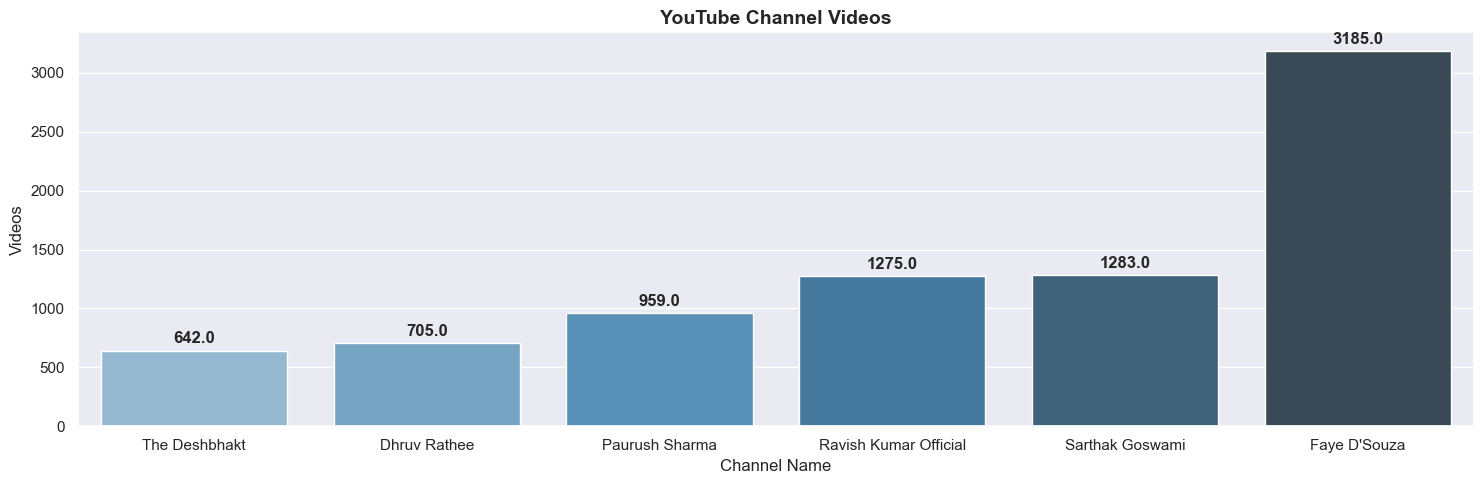

In [27]:
# total videos posted by the channel

sorted_df_asc = df.sort_values('videos')
order_asc = sorted_df_asc['channel_name']

sns.set(rc={'figure.figsize':(15,5)})

ax=sns.barplot(x='channel_name', y='videos', data=df, order=order_asc, palette='Blues_d')

for container in ax.containers:
    labels = [f'{v.get_height()}' for v in container]
    ax.bar_label(container, labels=labels, label_type='edge', padding=3, fontweight='bold')

ax.set_title('YouTube Channel Videos', fontsize=14, fontweight='bold')
ax.set_xlabel('Channel Name', fontsize=12)
ax.set_ylabel('Videos', fontsize=12)


# Show the plot
plt.tight_layout()
plt.show()

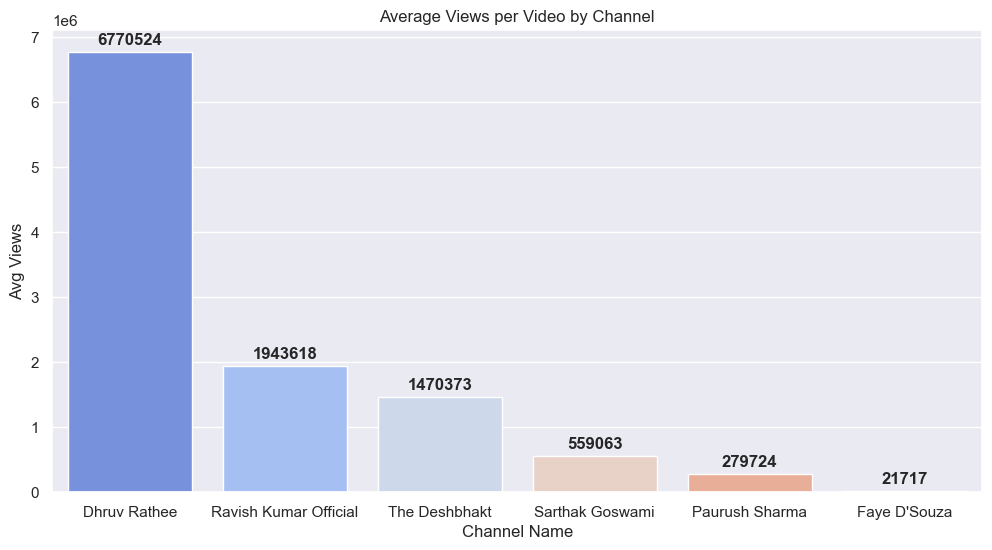

In [28]:
# average views per videos posted by the channel

sorted_df_asc = df.sort_values('avg_views_per_video', ascending=False)
order_asc = sorted_df_asc['channel_name']

plt.figure(figsize=(12,6))
ax=sns.barplot(data=df, x='channel_name', y='avg_views_per_video', order=order_asc, palette='coolwarm')

for container in ax.containers:
    labels = [f'{v.get_height():.0f}' for v in container]
    ax.bar_label(container, labels=labels, label_type='edge', padding=3, fontweight='bold')

    
plt.title("Average Views per Video by Channel")
plt.ylabel("Avg Views")
plt.xlabel("Channel Name")
plt.xticks(rotation=0)
plt.show()

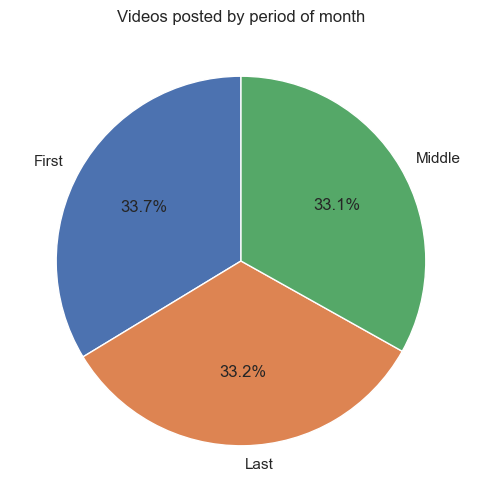

In [29]:
video_period_share = yt_data.groupby('posting_period')['video_id'].count()

plt.figure(figsize=(6,6))
plt.pie(
    video_period_share,
    labels=video_period_share.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Videos posted by period of month")
plt.show()



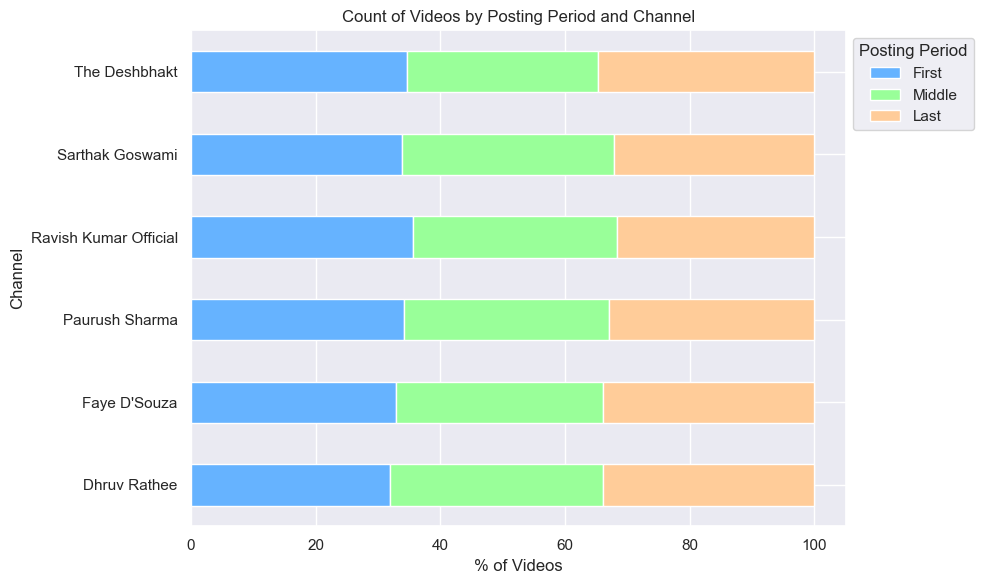

In [30]:
video_counts = yt_data.groupby(['channel_name', 'posting_period']).size().unstack(fill_value=0)

# Sort columns in logical order
video_counts = video_counts[['First', 'Middle', 'Last']]
video_perc = video_counts.div(video_counts.sum(axis=1), axis=0) * 100
# --- Plot horizontal stacked bar chart ---
video_perc.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    color=['#66b3ff', '#99ff99', '#ffcc99']
)

plt.title("Count of Videos by Posting Period and Channel")
plt.xlabel("% of Videos")
plt.ylabel("Channel")
plt.legend(title="Posting Period", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Engagement Summary Metrics

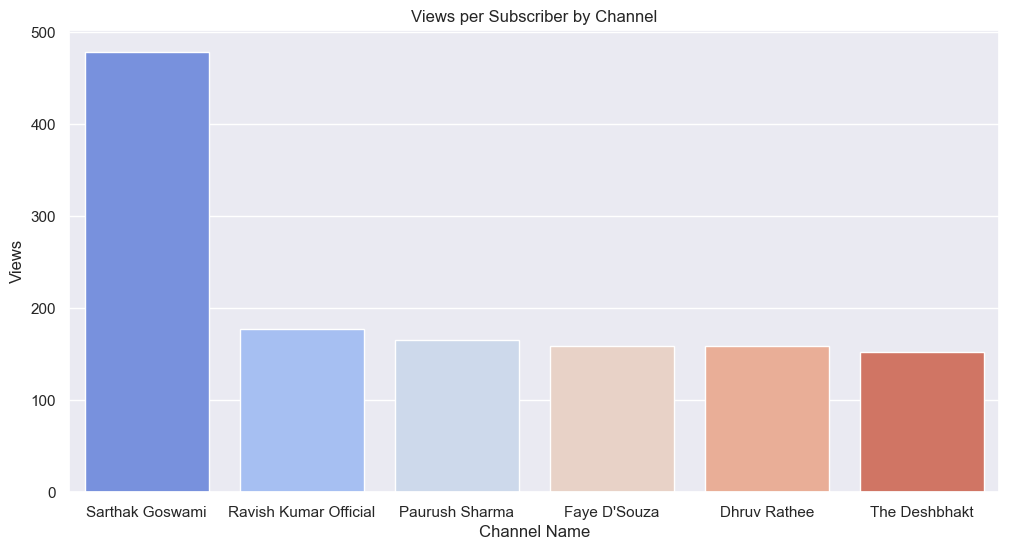

In [31]:
# views per subscriber

sorted_df_asc = df.sort_values('views_per_subscriber', ascending=False)
order_asc = sorted_df_asc['channel_name']

plt.figure(figsize=(12,6))
sns.barplot(data=df, x='channel_name', y='views_per_subscriber', order=order_asc, palette='coolwarm')

for container in ax.containers:
    labels = [f'{v.get_height():.0f}' for v in container]
    ax.bar_label(container, labels=labels, label_type='edge', padding=3, fontweight='bold')
    
plt.title("Views per Subscriber by Channel")
plt.ylabel("Views")
plt.xlabel("Channel Name")
plt.show()

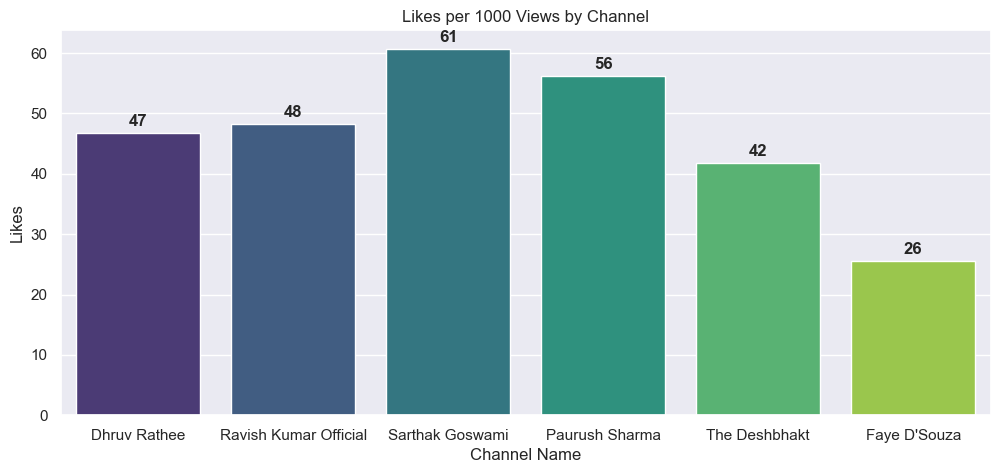

In [32]:
# Likes per 100 views

plt.figure(figsize=(12,5))
ax=sns.barplot(data=df, x='channel_name', y='likes_per_1000_views', palette='viridis')

for container in ax.containers:
    labels = [f'{v.get_height():.0f}' for v in container]
    ax.bar_label(container, labels=labels, label_type='edge', padding=3, fontweight='bold')
    
plt.title("Likes per 1000 Views by Channel")
plt.ylabel("Likes")
plt.xlabel("Channel Name")
plt.xticks(rotation=0)
plt.show()

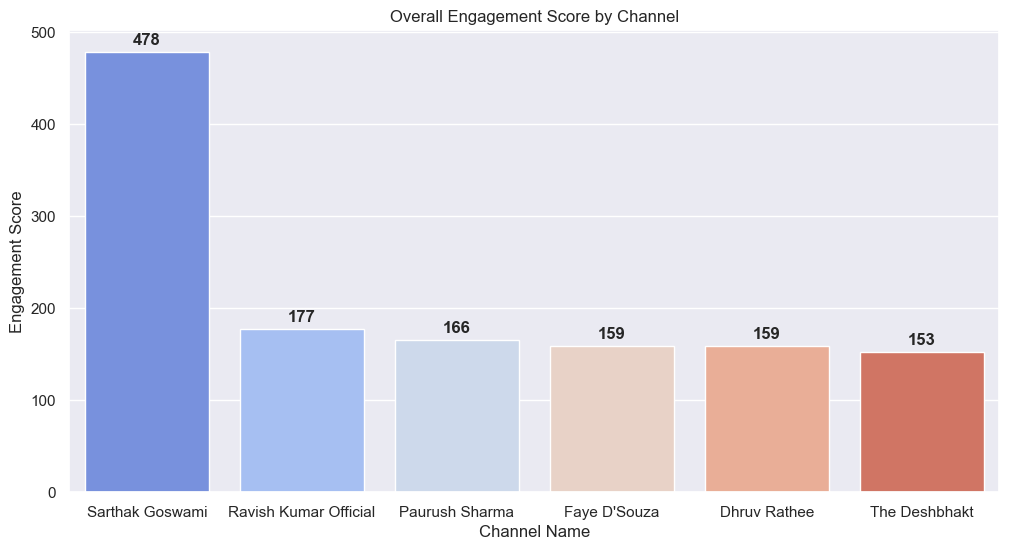

In [33]:
# Engagement score - audience interactions with its content 
# combining viewer engagement (likes) + audience reach (views per subscriber)

sorted_df_asc = df.sort_values('engagement_score', ascending=False)
order_asc = sorted_df_asc['channel_name']

plt.figure(figsize=(12,6))
ax=sns.barplot(data=df, x='channel_name', y='engagement_score', order=order_asc, palette='coolwarm')

for container in ax.containers:
    labels = [f'{v.get_height():.0f}' for v in container]
    ax.bar_label(container, labels=labels, label_type='edge', padding=3, fontweight='bold')
    

plt.title("Overall Engagement Score by Channel")
plt.ylabel("Engagement Score")
plt.xlabel("Channel Name")
plt.xticks(rotation=0)
plt.show()

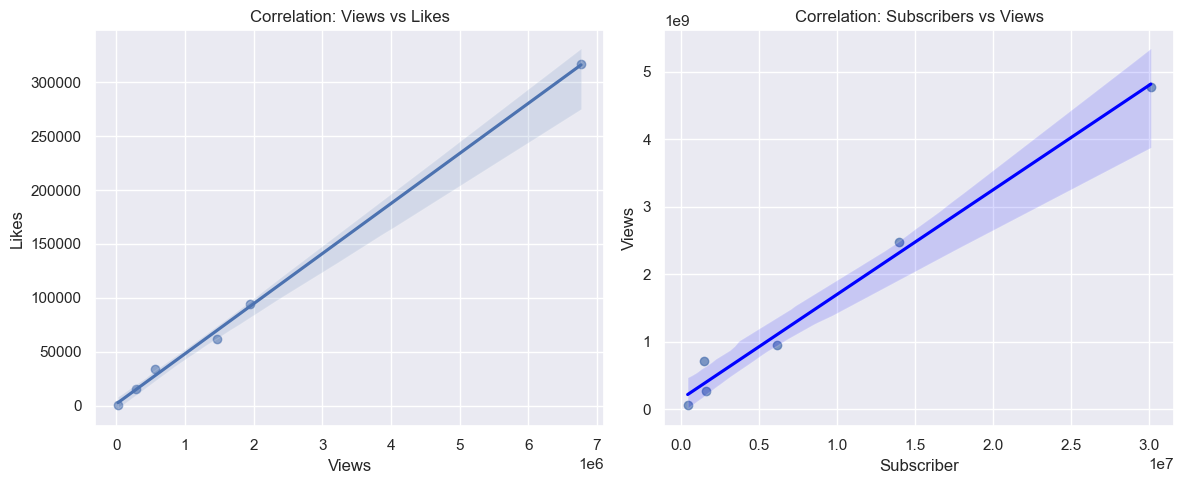

In [34]:
# Correlation between the metrics

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Correlation 1: Views vs Likes ---
sns.regplot(data=df, x='avg_views', y='avg_likes', ax=axes[0], scatter_kws={'alpha':0.6})
axes[0].set_title("Correlation: Views vs Likes")
axes[0].set_xlabel("Views")
axes[0].set_ylabel("Likes")

# --- Correlation 2: Views per Subscriber vs Likes per 1000 Views ---
sns.regplot(data=df, 
            x='subscribers', 
            y='total_views', 
            ax=axes[1], scatter_kws={'alpha':0.7}, line_kws={'color':'blue'})
axes[1].set_title("Correlation: Subscribers vs Views")
axes[1].set_xlabel("Subscriber")
axes[1].set_ylabel("Views")

plt.tight_layout()
plt.show()

In [35]:
channel = input("Please enter a channel name: ")

Please enter a channel name: Sarthak Goswami


In [36]:
# top 10 videos by the number of views by the selected channel name

select_channel= yt_data[yt_data['channel_name']==channel]

top_videos = select_channel.sort_values('views', ascending=False).head(10)
top_videos

,video_id,title,channel_id,publish_date,duration,views,likes,fav_count,channel_name,ch_subscribers,duration2,posting_period
2847,lpDiDzebn_w,ART है ये मज़ाक? #shorts,UC5fcjujOsqD-126Chn_BAuA,2022-08-26,PT1M,25150189,1723043.0,0,Sarthak Goswami,1500000,1.00,Last
2367,SjR41eEnkbY,Shaadi ka card hai yaa diss track! 😂 || #short...,UC5fcjujOsqD-126Chn_BAuA,2024-12-20,PT55S,25079218,813454.0,0,Sarthak Goswami,1500000,0.92,Middle
2795,7B8yeXPvn9Q,Undercover Cop Cracks College Ragging Case 😱 #...,UC5fcjujOsqD-126Chn_BAuA,2022-12-14,PT55S,23421054,1713735.0,0,Sarthak Goswami,1500000,0.92,Middle
2860,fgybv5E1xvY,50 CRORE CASH in Arpita Mukherjee ED raid!! 😱 ...,UC5fcjujOsqD-126Chn_BAuA,2022-07-28,PT51S,15112400,1172207.0,0,Sarthak Goswami,1500000,0.85,Last
2074,utwBlqjwR8Y,New technology in Bihar bridges! 🤯,UC5fcjujOsqD-126Chn_BAuA,2025-04-25,PT49S,9760602,405627.0,0,Sarthak Goswami,1500000,0.82,Last
2333,cIer49pBRVk,Aese banega desh Vishwaguru!? 😳🥲 || #shorts #y...,UC5fcjujOsqD-126Chn_BAuA,2025-01-08,PT44S,9309274,405902.0,0,Sarthak Goswami,1500000,0.73,First
2814,XOehAOeEI1M,Rs 280 only: World's cheapest Villa #shorts,UC5fcjujOsqD-126Chn_BAuA,2022-11-09,PT50S,9122257,680079.0,0,Sarthak Goswami,1500000,0.83,First
2848,h1Ie8p8vIcQ,Fake Police Station Exposed in Bihar 😂 #shorts,UC5fcjujOsqD-126Chn_BAuA,2022-08-24,PT56S,8121423,666575.0,0,Sarthak Goswami,1500000,0.93,Last
2859,VSetGO5-3tE,Rs 3500 CRORE Electricity Bill | Sunday Show ...,UC5fcjujOsqD-126Chn_BAuA,2022-07-30,PT59S,8077140,741542.0,0,Sarthak Goswami,1500000,0.98,Last
2062,Whda0tmhasQ,Military war ❌ Meme war ✅,UC5fcjujOsqD-126Chn_BAuA,2025-04-29,PT57S,7982601,339116.0,0,Sarthak Goswami,1500000,0.95,Last


In [37]:
# top 10 videos by the number of views by the selected channel name


top_videos = select_channel.sort_values('likes', ascending=False).head(10)
top_videos

,video_id,title,channel_id,publish_date,duration,views,likes,fav_count,channel_name,ch_subscribers,duration2,posting_period
2847,lpDiDzebn_w,ART है ये मज़ाक? #shorts,UC5fcjujOsqD-126Chn_BAuA,2022-08-26,PT1M,25150189,1723043.0,0,Sarthak Goswami,1500000,1.00,Last
2795,7B8yeXPvn9Q,Undercover Cop Cracks College Ragging Case 😱 #...,UC5fcjujOsqD-126Chn_BAuA,2022-12-14,PT55S,23421054,1713735.0,0,Sarthak Goswami,1500000,0.92,Middle
2860,fgybv5E1xvY,50 CRORE CASH in Arpita Mukherjee ED raid!! 😱 ...,UC5fcjujOsqD-126Chn_BAuA,2022-07-28,PT51S,15112400,1172207.0,0,Sarthak Goswami,1500000,0.85,Last
2367,SjR41eEnkbY,Shaadi ka card hai yaa diss track! 😂 || #short...,UC5fcjujOsqD-126Chn_BAuA,2024-12-20,PT55S,25079218,813454.0,0,Sarthak Goswami,1500000,0.92,Middle
2859,VSetGO5-3tE,Rs 3500 CRORE Electricity Bill | Sunday Show ...,UC5fcjujOsqD-126Chn_BAuA,2022-07-30,PT59S,8077140,741542.0,0,Sarthak Goswami,1500000,0.98,Last
2814,XOehAOeEI1M,Rs 280 only: World's cheapest Villa #shorts,UC5fcjujOsqD-126Chn_BAuA,2022-11-09,PT50S,9122257,680079.0,0,Sarthak Goswami,1500000,0.83,First
2848,h1Ie8p8vIcQ,Fake Police Station Exposed in Bihar 😂 #shorts,UC5fcjujOsqD-126Chn_BAuA,2022-08-24,PT56S,8121423,666575.0,0,Sarthak Goswami,1500000,0.93,Last
2850,zJ_P_uXur9g,Bollywood style Income Tax Raid! #shorts,UC5fcjujOsqD-126Chn_BAuA,2022-08-18,PT47S,5053717,542653.0,0,Sarthak Goswami,1500000,0.78,Middle
2931,O3-Nkb0qibU,Carryminati's funny exam advice | Funny Video,UC5fcjujOsqD-126Chn_BAuA,2020-05-11,PT1M,6255000,429630.0,0,Sarthak Goswami,1500000,1.00,Middle
2333,cIer49pBRVk,Aese banega desh Vishwaguru!? 😳🥲 || #shorts #y...,UC5fcjujOsqD-126Chn_BAuA,2025-01-08,PT44S,9309274,405902.0,0,Sarthak Goswami,1500000,0.73,First
